In [2]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體 (若系統無此字體，請自行安裝或修改)
# 這裡使用 'Arial Unicode MS' 作為範例，若執行環境無法顯示中文，請替換成系統中有的中文字體
# 例如：'SimHei' (黑體, 簡體中文常用), 'Microsoft JhengHei' (微軟正黑體, 繁體中文常用)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False # 解決負號亂碼問題

# 原始數據字串
data_string = """
	嬰兒(0歲)—總數		嬰兒(0歲)—新生兒(0-4週)		1-4歲		5-14歲		15-24歲		25-44歲		45-64歲		65歲以上	
	男	女	男	女	男	女	男	女	男	女	男	女	男	女	男	女
2013	416.4	348.3	197.3	218.4	15	22.8	13.4	10.3	42.2	20	140.3	62	676	283.4	4,504.00	2,877.60
2014	442.8	315.7	286.8	224.7	32.1	20.6	15.9	8.9	42.4	16.5	143.4	61.3	679.6	289.4	4,524.00	2,953.40
2015	450.3	367.3	268	235.3	20	15.4	10.7	8.8	51.1	25.5	143.9	62.5	687.1	293.1	4,269.20	2,827.10
2016	464.3	363.9	294.4	230.5	21	16.5	12.3	19.6	49.1	26	146.7	64.5	708.8	278.7	4,326.00	2,752.10
2017	499.1	357.3	338.9	227.4	18.6	9.2	11.4	8.1	44.7	25.4	138.6	61	675.6	298.4	4,033.00	2,719.60
2018	498.8	359.5	303.3	258.8	19.3	14.2	10.9	10	45.8	18.1	128.8	67.9	677.7	275.3	3,908.70	2,586.20
2019	546.9	451.2	401.6	340.2	18.2	14.6	12.7	10	52.4	22.8	130.2	58.8	701.5	286.5	3,788.30	2,530.80
2020	389.4	396.2	259.6	291.1	29.6	18.3	7.5	8.1	59.2	27	118.5	55.2	643.6	281.4	3,572.60	2,371.10
2021	547.1	360.3	390.8	243	17.9	5.2	11	9.3	40	28.3	126.4	65.5	675	283.1	3,812.50	2,543.50
2022	454.2	428.6	299.8	272.8	18.8	25.6	12.8	6.9	45.2	28.8	125.7	63.8	730.7	298.3	4,277.10	2,788.20
2023	690.4	472.6	517.8	292.6	28.8	19.2	14	10	46.7	35.1	132	64.7	729.8	290.3	3,891.00	2,550.10
"""

# 1. 數據載入和清理
# 讀取數據，使用 StringIO 模擬文件讀取，sep='\s+' 處理多個空格分隔
df = pd.read_csv(io.StringIO(data_string), sep='\s+', header=None, skiprows=2, index_col=0)

# 獲取年齡層級標題 (第 1 行)
age_groups = [
    '嬰兒(0歲)—總數', '嬰兒(0歲)—新生兒(0-4週)', '1-4歲', '5-14歲', 
    '15-24歲', '25-44歲', '45-64歲', '65歲以上'
]

# 創建多層級欄位名稱
columns = pd.MultiIndex.from_product([age_groups, ['男', '女']])
df.columns = columns

# 清理數據：移除千分位逗號並轉換為數值型態 (float)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 重新命名索引 (年份)
df.index.name = '期間'

# 數據重塑 (Melt/Unpivot) 以便於 seaborn 繪圖
df_melted = df.stack(level=[0, 1]).reset_index()
df_melted.columns = ['期間', '年齡層', '性別', '死亡率']

print("--- 數據前五行 (Melted) ---")
print(df_melted.head())
print("-" * 30)

# ----------------------------------------------------
# 2. 各種分析圖表範例
# ----------------------------------------------------

# --- A. 時間序列分析：觀察特定年齡層死亡率的年度趨勢 (折線圖) ---
def plot_age_group_trend(age_group):
    """繪製特定年齡層死亡率的年度趨勢圖"""
    df_plot = df_melted[df_melted['年齡層'] == age_group]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_plot, x='期間', y='死亡率', hue='性別', marker='o')
    plt.title(f'{age_group} 死亡率年度趨勢 (人/十萬人)')
    plt.xlabel('期間 (年)')
    plt.ylabel('死亡率 (人/十萬人)')
    plt.xticks(df_plot['期間'].unique(), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='性別')
    plt.tight_layout()
    plt.show()

# 範例 1：嬰兒(0歲)—總數 的趨勢
plot_age_group_trend('嬰兒(0歲)—總數')

# 範例 2：65歲以上 的趨勢 (死亡率最高的一組)
plot_age_group_trend('65歲以上')

# --- B. 跨年齡層比較：在特定年份，不同年齡層死亡率的差異 (長條圖) ---
def plot_age_comparison_by_year(year):
    """繪製特定年份各年齡層的死亡率比較圖"""
    df_plot = df_melted[df_melted['期間'] == year]
    
    plt.figure(figsize=(14, 7))
    # 使用 log 尺度來處理數值差異大的情況，例如嬰兒與 65歲以上
    sns.barplot(data=df_plot, x='年齡層', y='死亡率', hue='性別', palette='viridis', log=True)
    plt.title(f'{year} 年各年齡層死亡率比較 (Log Scale)')
    plt.xlabel('年齡層')
    plt.ylabel('死亡率 (人/十萬人, Log Scale)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='性別')
    plt.tight_layout()
    plt.show()

# 範例 3：2023 年的各年齡層比較
plot_age_comparison_by_year(2023)

# --- C. 性別差異分析：各年齡層的男女性別差異趨勢 (線圖/分面圖) ---
# 計算男女死亡率比值 (男性/女性)
df_gender_ratio = df.copy()
gender_ratio_cols = pd.MultiIndex.from_product([age_groups, ['比值 (男/女)']])
df_gender_ratio.columns = gender_ratio_cols # 重設為單層

# 計算比值並轉換為長格式
ratio_data = {}
for group in age_groups:
    ratio_data[group] = df[(group, '男')] / df[(group, '女')]

df_ratio = pd.DataFrame(ratio_data, index=df.index).stack().reset_index()
df_ratio.columns = ['期間', '年齡層', '比值']

# 範例 4：男女性別死亡率比值年度趨勢 (男/女)
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_ratio, x='期間', y='比值', hue='年齡層', marker='o')
plt.axhline(1, color='r', linestyle='--', label='比值=1 (男女相等)') # 添加基準線
plt.title('各年齡層男女性別死亡率比值 (男/女) 年度趨勢')
plt.xlabel('期間 (年)')
plt.ylabel('男性死亡率 / 女性死亡率')
plt.xticks(df_ratio['期間'].unique(), rotation=45)
plt.legend(title='年齡層', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- D. 分面圖 (Facet Grid)：同時比較所有年齡層的年度趨勢 ---
# 範例 5：使用 FacetGrid 繪製所有年齡層的年度趨勢
g = sns.FacetGrid(df_melted, col='年齡層', col_wrap=4, hue='性別', 
                  sharey=False, palette='coolwarm', height=4, aspect=1.2)
g.map(sns.lineplot, '期間', '死亡率', marker='o')

# 調整子圖標題
g.set_titles(col_template="{col_name} 死亡率")

# 調整 X 軸刻度
for ax in g.axes.flat:
    # 僅在 X 軸上顯示年份
    ax.set_xticks(df_melted['期間'].unique())
    # 旋轉 X 軸標籤以避免重疊
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle=':', alpha=0.5)

# 添加圖例 (只在第一個圖中添加)
g.add_legend(title='性別')

# 調整大圖標題和佈局
plt.suptitle('所有年齡層死亡率年度趨勢比較', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

ParserError: Error tokenizing data. C error: Expected 16 fields in line 4, saw 17


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


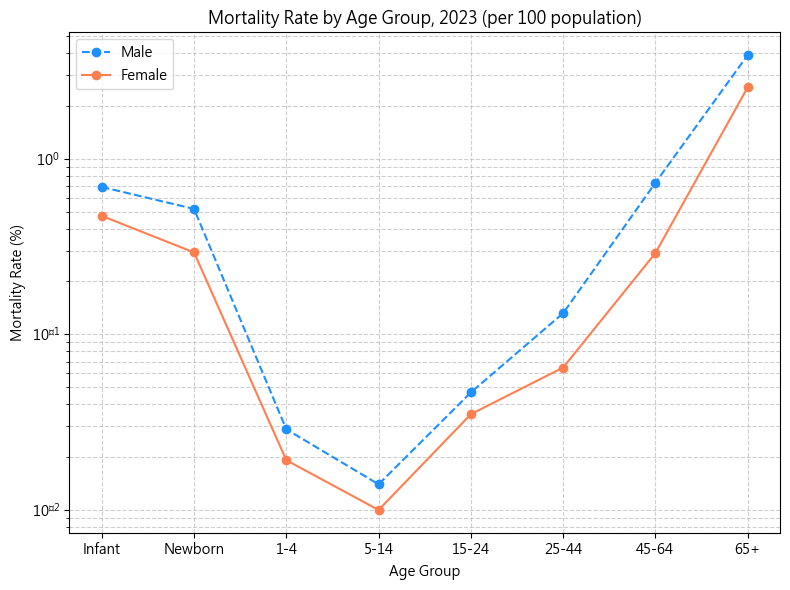

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data for 2023
age_groups = ["Infant", "Newborn", "1-4", "5-14", "15-24", "25-44", "45-64", "65+"]
male_2023 = [690.4, 517.8, 28.8, 14.0, 46.7, 132.0, 729.8, 3891.0]
female_2023 = [472.6, 292.6, 19.2, 10.0, 35.1, 64.7, 290.3, 2550.1]

# Convert per 100k to per 100 (%)
male_rate = np.array(male_2023) / 1000
female_rate = np.array(female_2023) / 1000

plt.figure(figsize=(8,6))
plt.plot(age_groups, male_rate, 'o--', label='Male', color='dodgerblue')
plt.plot(age_groups, female_rate, 'o-', label='Female', color='coral')

plt.yscale('log')
plt.title("Mortality Rate by Age Group, 2023 (per 100 population)")
plt.xlabel("Age Group")
plt.ylabel("Mortality Rate (%)")
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
